# Custom Gym State

## imports

In [20]:
import sys
sys.executable

'/home/cbosmans/Documents/Projects/openai/openai/bin/python'

In [21]:
import gym 
import random
from nes_py.wrappers import JoypadSpace
import gym_tetris
from gym_tetris.actions import MOVEMENT, SIMPLE_MOVEMENT
import cv2
import time
import matplotlib.pyplot as plt

In [22]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

In [23]:
## use pip install --upgrade --force-reinstall  git+https://github.com/Bosmansc/tetris_openai.git
## not pip install  pip install keras-rl2, this is not compatible with tetris environment

from rl.agents import DQNAgent
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory

## Env

In [24]:
env = gym_tetris.make('TetrisA-v3') ## A V3 rewards lines and penalizes height
env = JoypadSpace(env, SIMPLE_MOVEMENT) ## use simple movement for simplicity

states = env.observation_space.shape[0]
actions = env.action_space.n

In [25]:
print("there are {} default states and {} actions".format(states, actions))

there are 240 default states and 6 actions


## Env State wrapper

In [26]:
class ObservationWrapper(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
    
    def observation(self, obs):
        obs = self._resize(obs)
        return obs
    
    def _resize(self, img, downsize=(10,20)):
        resized = cv2.resize(img[47:209,95:176],
                             dsize=downsize,
                             interpolation=cv2.INTER_CUBIC)
        resized = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
        return (resized>1).astype(int)

In [27]:
env_custom = ObservationWrapper(gym.make("TetrisA-v3"))
env_custom = JoypadSpace(env_custom, SIMPLE_MOVEMENT) ## use simple movement for simplicity

states = env_custom.observation_space.shape[0]
actions = env_custom.action_space.n

print("there are {} states and {} actions".format(states, actions))

there are 240 states and 6 actions


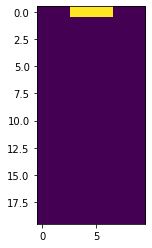

(20, 10)


In [28]:
state = env_custom.reset()
plt.imshow(state)
plt.show()
print(state.shape)

In [29]:
## random env to check if everything works

episodes = 1
for episode in range(1, episodes+1):
    state = env_custom.reset()
    done = False
    score = 0 
    
    for i in range(100):
        env_custom.render()
        action = env.action_space.sample()
       # action = 2
       # action = random.sample([1, 2], 1)[0]
        n_state, reward, done, info = env_custom.step(action)
        #print(n_state)
        score+=reward


In [14]:
env.close()

# Deep Q learning

In [30]:
def build_model_conv(states, actions):
    
    ## edit state based on code Seyedomid
    #resize(state)
    
    # Network defined by the Deepmind paper
    model = tf.keras.models.Sequential()
    
    model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform', 
                     kernel_constraint=max_norm(4), input_shape=(1, 20, 10)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
  #  model.add(Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform'))
  #  model.add(BatchNormalization())
  #  model.add(Activation('relu'))
    
  #  model.add(Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform'))
  #  model.add(BatchNormalization())
  #  model.add(Activation('relu'))
  #  model.add(MaxPooling2D(pool_size=(2,2)))
    
    
    # end of convolutional layers, start of 'hidden' dense layers 
    model.add(Flatten())
    model.add(Dense(128, kernel_initializer='he_uniform', kernel_constraint=max_norm(3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    
    # Final dense layer
    model.add(Dense(actions, activation='linear'))
    
    return model

In [31]:
model = build_model_conv(states, actions)
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 1, 20, 32)         2912      
_________________________________________________________________
batch_normalization_4 (Batch (None, 1, 20, 32)         128       
_________________________________________________________________
activation_4 (Activation)    (None, 1, 20, 32)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 640)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               82048     
_________________________________________________________________
batch_normalization_5 (Batch (None, 128)               512       
_________________________________________________________________
activation_5 (Activation)    (None, 128)              

In [32]:
def build_agent(model, actions):
    policy = BoltzmannQPolicy()
    memory = SequentialMemory(limit=50000, window_length=1)
    dqn = DQNAgent(model=model, memory=memory, policy=policy, 
                  nb_actions=actions, nb_steps_warmup=10, target_model_update=1e-2)
    return dqn

In [33]:
dqn = build_agent(model, actions)
dqn.compile(Adam(lr=1e-3), metrics=['mae'])
dqn.fit(env_custom, nb_steps=20000, visualize=True)

Training for 20000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 166s 17ms/step - reward: -0.0016
Interval 2 (10000 steps performed)
10000/10000 [==============================] - 161s 16ms/step - reward: -0.0020
done, took 327.537 seconds


In [ ]:
scores = dqn.test(env_custom, nb_episodes=1, visualize=True)
print(np.mean(scores.history['episode_reward']))